In [1]:
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
import tqdm
import time
import os
import wandb
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from external_utils import format_time
from utils.data_preprocessing import preprocess_dataset_get_data_loader, generate_merged_dataset_from_two_loader, generate_dataset_from_loader,preprocess_mnist_fmnist,get_data_loader
from structure.dlgn_conv_config_structure import DatasetConfig
from collections import OrderedDict

from visualization import recreate_image, save_image,  PerClassDataset
from utils.data_preprocessing import true_segregation
from structure.generic_structure import CustomSimpleDataset
from adversarial_attacks_tester import generate_adv_examples
from configs.dlgn_conv_config import HardRelu

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)

from keras.datasets import mnist, fashion_mnist

from conv4_models import get_model_instance, get_model_instance_from_dataset


def get_model_from_path(dataset, model_arch_type, model_path, mask_percentage=40,custom_model=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    temp_model = torch.load(model_path, map_location=device)
    if(custom_model is None):
        custom_model = get_model_instance_from_dataset(
            dataset, model_arch_type)
    if("masked" in model_arch_type):
        custom_model = get_model_instance_from_dataset(
            dataset, model_arch_type, mask_percentage=mask_percentage)
    if(isinstance(temp_model, dict)):
        if("module." in [*temp_model['state_dict'].keys()][0]):
            new_state_dict = OrderedDict()
            for k, v in temp_model['state_dict'].items():
                name = k[7:]  # remove 'module.' of dataparallel
                new_state_dict[name] = v
            custom_model.load_state_dict(new_state_dict)
        else:
            custom_model.load_state_dict(temp_model['state_dict'])
    else:
        custom_model.load_state_dict(temp_model.state_dict())

    return custom_model

2023-07-22 18:59:35.044689: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-22 18:59:35.045008: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 18:59:35.051521: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
def get_fixedNPVs(model):
    prev = None
    if(hasattr(model,"value_network")):
        src = model.value_network.list_of_modules
    else:
        src = model.list_of_modules
    for each_module in src:
        cur_w = each_module.weight
        if(prev is None):
            prev = torch.transpose(cur_w,0,1)
        else:
            tmp=[]
            for i in range(prev.size()[0]):
                t1 = torch.unsqueeze(prev[i],0)
                rtmp = torch.transpose(cur_w*t1,0,1)
                tmp.append(torch.reshape(rtmp,(np.prod(list(rtmp.size())),1)))
                
            prev = torch.squeeze(torch.stack(tmp))
    
    if(not hasattr(model,"value_network")):
        cur_w = model.output_layer.weight
        tmp=[]
        for i in range(prev.size()[0]):
            t1 = torch.unsqueeze(prev[i],0)
            rtmp = torch.transpose(cur_w*t1,0,1)
            tmp.append(torch.reshape(rtmp,(np.prod(list(rtmp.size())),1)))
            
        prev = torch.squeeze(torch.stack(tmp))

    return torch.squeeze(torch.reshape(prev,(np.prod(list(prev.size())),1)))

def get_NPFs(outlists):
    prev = None
    for cur_w in outlists:
        if(prev is None):
            prev = torch.transpose(cur_w,0,1)
        else:
            cur_w = torch.transpose(cur_w,0,1)
            tmp=[]
            for i in range(prev.size()[0]):
                t1 = torch.unsqueeze(prev[i],0)
                rtmp = torch.transpose(t1*cur_w,0,1)
                tmp.append(rtmp)
                
            prev = torch.transpose(torch.concat(tmp,dim=1),0,1)
    
    return prev

In [19]:
dataset = 'mnist'
# conv4_dlgn , plain_pure_conv4_dnn , conv4_dlgn_n16_small , plain_pure_conv4_dnn_n16_small , conv4_deep_gated_net , conv4_deep_gated_net_n16_small
# fc_dnn , fc_dlgn , fc_dgn , dlgn__conv4_dlgn_pad_k_1_st1_bn_wo_bias__
model_arch_type = 'fc_dnn'
batch_size = 64

is_analysis_on_train = False

torch_seed = 2022

# None means that train on all classes
list_of_classes_to_train_on = None
list_of_classes_to_train_on = [3,8]

# Percentage of information retention during PCA (values between 0-1)
pca_exp_percent = None
# pca_exp_percent = 0.85

is_analyse_adv = True

wandb_config_additional_dict = None
# wandb_config_additional_dict = {"type_of_APR": "APRS"}

# direct_model_path = "root/model/save/mnist/CLEAN_TRAINING/TR_ON_3_8/ST_2022/fc_dlgn_W_10_D_2_dir.pt"
# direct_model_path = "root/model/save/mnist/adversarial_training/TR_ON_3_8/MT_fc_dlgn_W_10_D_2_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.06/batch_size_128/eps_stp_size_0.06/adv_steps_80/adv_model_dir.pt"

# direct_model_path = "root/model/save/mnist/CLEAN_TRAINING/TR_ON_3_8/ST_2022/fc_dnn_W_10_D_1_dir.pt"
direct_model_path = "root/model/save/mnist/adversarial_training/TR_ON_3_8/MT_fc_dnn_W_10_D_1_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.06/batch_size_128/eps_stp_size_0.06/adv_steps_80/adv_model_dir.pt"

custom_dataset_path = None
# custom_dataset_path = "data/custom_datasets/freq_band_dataset/mnist__MB_HB.npy"

if(dataset == "cifar10"):
    inp_channel = 3
    classes = ('plane', 'car', 'bird', 'cat',
                'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    num_classes = len(classes)

    cifar10_config = DatasetConfig(
        'cifar10', is_normalize_data=False, valid_split_size=0.1, batch_size=batch_size, 
        list_of_classes=list_of_classes_to_train_on,custom_dataset_path=custom_dataset_path)

    trainloader, _, testloader = preprocess_dataset_get_data_loader(
        cifar10_config, model_arch_type, verbose=1, dataset_folder="./Datasets/", is_split_validation=False)

elif(dataset == "mnist"):
    inp_channel = 1
    classes = [str(i) for i in range(0, 10)]
    num_classes = len(classes)

    ds_config = DatasetConfig(
        'mnist', is_normalize_data=True, valid_split_size=0.1, batch_size=batch_size, 
        list_of_classes=list_of_classes_to_train_on,custom_dataset_path=custom_dataset_path)

    trainloader, _, testloader = preprocess_dataset_get_data_loader(
        ds_config, model_arch_type, verbose=1, dataset_folder="./Datasets/", is_split_validation=False)

elif(dataset == "fashion_mnist"):
    inp_channel = 1
    classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle-boot')
    num_classes = len(classes)

    ds_config = DatasetConfig(
        'fashion_mnist', is_normalize_data=True, valid_split_size=0.1, batch_size=batch_size, 
        list_of_classes=list_of_classes_to_train_on,custom_dataset_path=custom_dataset_path)

    trainloader, _, testloader = preprocess_dataset_get_data_loader(
        ds_config, model_arch_type, verbose=1, dataset_folder="./Datasets/", is_split_validation=False)

if(custom_dataset_path is not None):
    dataset = custom_dataset_path[custom_dataset_path.rfind("/")+1:custom_dataset_path.rfind(".npy")]

print("Testing over "+dataset)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes_trained_on = num_classes
dataset_str = dataset

list_of_classes_to_train_on_str = ""
if(list_of_classes_to_train_on is not None):
    for each_class_to_train_on in list_of_classes_to_train_on:
        list_of_classes_to_train_on_str += \
            str(each_class_to_train_on)+"_"
    dataset_str += "_"+str(list_of_classes_to_train_on_str)
    list_of_classes_to_train_on_str = "TR_ON_" + \
        list_of_classes_to_train_on_str[0:-1]
    num_classes_trained_on = len(list_of_classes_to_train_on)
    temp_classes = []
    for ea_c in list_of_classes_to_train_on:
        temp_classes.append(classes[ea_c])
    classes = temp_classes

model_arch_type_str = model_arch_type
if("masked" in model_arch_type):
    mask_percentage = 90
    model_arch_type_str = model_arch_type_str + \
        "_PRC_"+str(mask_percentage)
    net = get_model_instance(
        model_arch_type, inp_channel, mask_percentage=mask_percentage, seed=torch_seed, num_classes=num_classes_trained_on)
elif("fc" in model_arch_type):
    fc_width = 10
    fc_depth = 1
    nodes_in_each_layer_list = [fc_width] * fc_depth
    model_arch_type_str = model_arch_type_str + \
        "_W_"+str(fc_width)+"_D_"+str(fc_depth)
    net = get_model_instance_from_dataset(dataset,
                                            model_arch_type, seed=torch_seed, num_classes=num_classes_trained_on, nodes_in_each_layer_list=nodes_in_each_layer_list)
else:
    net = get_model_instance(model_arch_type, inp_channel,
                                seed=torch_seed, num_classes=num_classes_trained_on)

if(pca_exp_percent is not None):
    dataset_for_pca = generate_dataset_from_loader(trainloader)
    if(isinstance(dataset_for_pca.list_of_x[0], torch.Tensor)):
        dataset_for_pca = torch.stack(
            dataset_for_pca.list_of_x), torch.stack(dataset_for_pca.list_of_y)
    else:
        dataset_for_pca = np.array(dataset_for_pca.list_of_x), np.array(
            dataset_for_pca.list_of_y)
    number_of_components_for_pca = net.initialize_PCA_transformation(
        dataset_for_pca[0], pca_exp_percent)
    model_arch_type_str = model_arch_type_str + \
        "_PCA_K"+str(number_of_components_for_pca) + \
        "_P_"+str(pca_exp_percent)

if('CLEAN' in direct_model_path or 'APR_TRAINING' in direct_model_path or 'adv_model_dir_epoch' in direct_model_path):
    data_save_prefix = direct_model_path[0:direct_model_path.rfind(
        ".pt")]
else:
    data_save_prefix = direct_model_path[0:direct_model_path.rfind(
        "/")+1]

isExist = os.path.exists(direct_model_path)
assert isExist == True, 'Model path does not have saved model'

net = get_model_from_path(
    dataset, model_arch_type, direct_model_path,custom_model=net)

net = net.to(device)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
if device_str == 'cuda':
    cudnn.benchmark = True

if(is_analysis_on_train == True):
    eval_loader = trainloader
else:
    eval_loader = testloader

class_indx_to_visualize = [i for i in range(len(classes))]
# class_indx_to_visualize= []

if(is_analyse_adv):
    number_of_adversarial_optimization_steps = 161
    adv_attack_type = "PGD"
    adv_target = None
    eps_step_size = 0.06
    eps = 0.06
    is_adv_attack_on_train = is_analysis_on_train

    final_adv_postfix_for_save = "/RAW_ADV_SAVES/adv_type_{}/EPS_{}/eps_stp_size_{}/adv_steps_{}/on_train_{}/".format(
            adv_attack_type, eps, eps_step_size, number_of_adversarial_optimization_steps, is_adv_attack_on_train)
    adv_save_path = data_save_prefix + \
        final_adv_postfix_for_save+"/adv_dataset.npy"
    is_current_adv_aug_available = os.path.exists(
        adv_save_path)
    if(is_current_adv_aug_available):
        with open(adv_save_path, 'rb') as file:
            npzfile = np.load(adv_save_path)
            list_of_adv_images = npzfile['x']
            list_of_labels = npzfile['y']
            adv_dataset = CustomSimpleDataset(
                list_of_adv_images, list_of_labels)
            print("Loading adversarial examples from path:",
                    adv_save_path)
    else:
        print("adv_save_path:", adv_save_path)
        adv_dataset = generate_adv_examples(
            eval_loader, net, eps, adv_attack_type, number_of_adversarial_optimization_steps, eps_step_size, adv_target, is_save_adv=True, save_path=adv_save_path)
    
    to_be_analysed_adversarial_dataloader = torch.utils.data.DataLoader(
                    adv_dataset, shuffle=False, batch_size=batch_size)
    true_tobe_analysed_dataset_per_class = true_segregation(
                    to_be_analysed_adversarial_dataloader, num_classes_trained_on)

true_eval_dataset_per_class = true_segregation(
    eval_loader, num_classes_trained_on)

npvs = get_fixedNPVs(net)
overall_sorted_npv_indx = torch.argsort(npvs)
pos_npv_indx = (npvs >0).nonzero()
neg_npv_indx = (npvs <0).nonzero()
pos_npvs = torch.squeeze(npvs[pos_npv_indx])
sorted_pos_npv_indx = torch.argsort(pos_npvs)
neg_npvs = torch.squeeze(npvs[neg_npv_indx])
sorted_neg_npv_indx = torch.argsort(neg_npvs)
print("npvs:{} Max NPV:{} Min NPV:{}  npvs positive count:{} npvs negative count:{}".format(npvs.size(),torch.max(npvs),torch.min(npvs),pos_npvs.numel(),neg_npvs.numel()))
print("pos_npvs:{} Max NPV:{} Min NPV:{}".format(pos_npvs.size(),torch.max(pos_npvs),torch.min(pos_npvs)))
print("neg_npvs:{} Max NPV:{} Min NPV:{} ".format(neg_npvs.size(),torch.max(neg_npvs),torch.min(neg_npvs)))

Testing over mnist
Loading adversarial examples from path: root/model/save/mnist/adversarial_training/TR_ON_3_8/MT_fc_dnn_W_10_D_1_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.06/batch_size_128/eps_stp_size_0.06/adv_steps_80//RAW_ADV_SAVES/adv_type_PGD/EPS_0.06/eps_stp_size_0.06/adv_steps_161/on_train_False//adv_dataset.npy


Processing original loader: 100%|██████████| 31/31 [00:00<00:00, 68.88it/s]


npvs:torch.Size([15680]) Max NPV:1.2249842882156372 Min NPV:-1.027945876121521  npvs positive count:7840 npvs negative count:7840
pos_npvs:torch.Size([7840]) Max NPV:1.2249842882156372 Min NPV:9.724391247800668e-08
neg_npvs:torch.Size([7840]) Max NPV:-7.919501143760499e-08 Min NPV:-1.027945876121521 


In [132]:
def output_bar_graph(xlist,ylist,title=""):
    # col = ['blue'if i%2==0 else 'red' for i in range(len(xlist))]
    # fig = plt.figure(figsize =(len(xlist)//100, len(ylist)//100))
    fig = plt.figure(figsize=(100,100))
    ax = fig.add_subplot(111)
    # while(xticks[-1]<len(xlist)):
    #     xticks.append(xticks[-1]+10)
    # ax.set_xlim(min(xlist), max(xlist))
    # ax.set_ylim(min(ylist), max(ylist))
    # ax.ticklabel_format(useOffset=False)
    # ax.bar(xlist,ylist)
    # ax.set_title(title)
    # fig.tight_layout()
    # fig.savefig(path,bbox_inches='tight')
    # fig.clear()
    svm = sns.barplot(x=xlist,y=ylist,ax=ax)
    svm.set_xticklabels(svm.get_xticklabels(), rotation=45, ha='right',fontsize=20)
    svm.set_yticklabels(svm.get_yticks(), size = 25)
    # svm.set_yticklabels(svm.get_yticklabels(),size=20)
    # svm.set(xticklabels=[])
    plt.title(label=title+"_"+str(min(xlist))+"-"+str(max(xlist)),fontsize=40)
    # svm.set(title=title+"_"+str(min(xlist))+"-"+str(max(xlist)))
    # svm.set(font_scale=2)
    # svm.set(xlabel=None)
    figure = svm.get_figure()
    # figure.tight_layout()
    plt.show()
    plt.close()

In [133]:
c_indx = 0
class_label = classes[c_indx]
print(
    "************************************************************ Class:", class_label)
per_class_eval_dataset = PerClassDataset(
    true_eval_dataset_per_class[c_indx], c_indx)
if(is_analyse_adv):
    per_class_tobe_analysed_dataset = PerClassDataset(
                            true_tobe_analysed_dataset_per_class[c_indx], c_indx)

************************************************************ Class: 3


In [135]:
npvs[overall_sorted_npv_indx].size()

torch.Size([15680])

In [141]:
sample_ind = 1
st = 0
end = 100

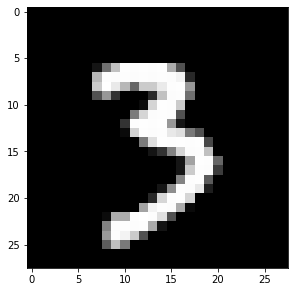

In [137]:
plt.figure(figsize=(6.4, 4.8), constrained_layout=False)
plt.imshow(per_class_eval_dataset[sample_ind][0], "gray")

/home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


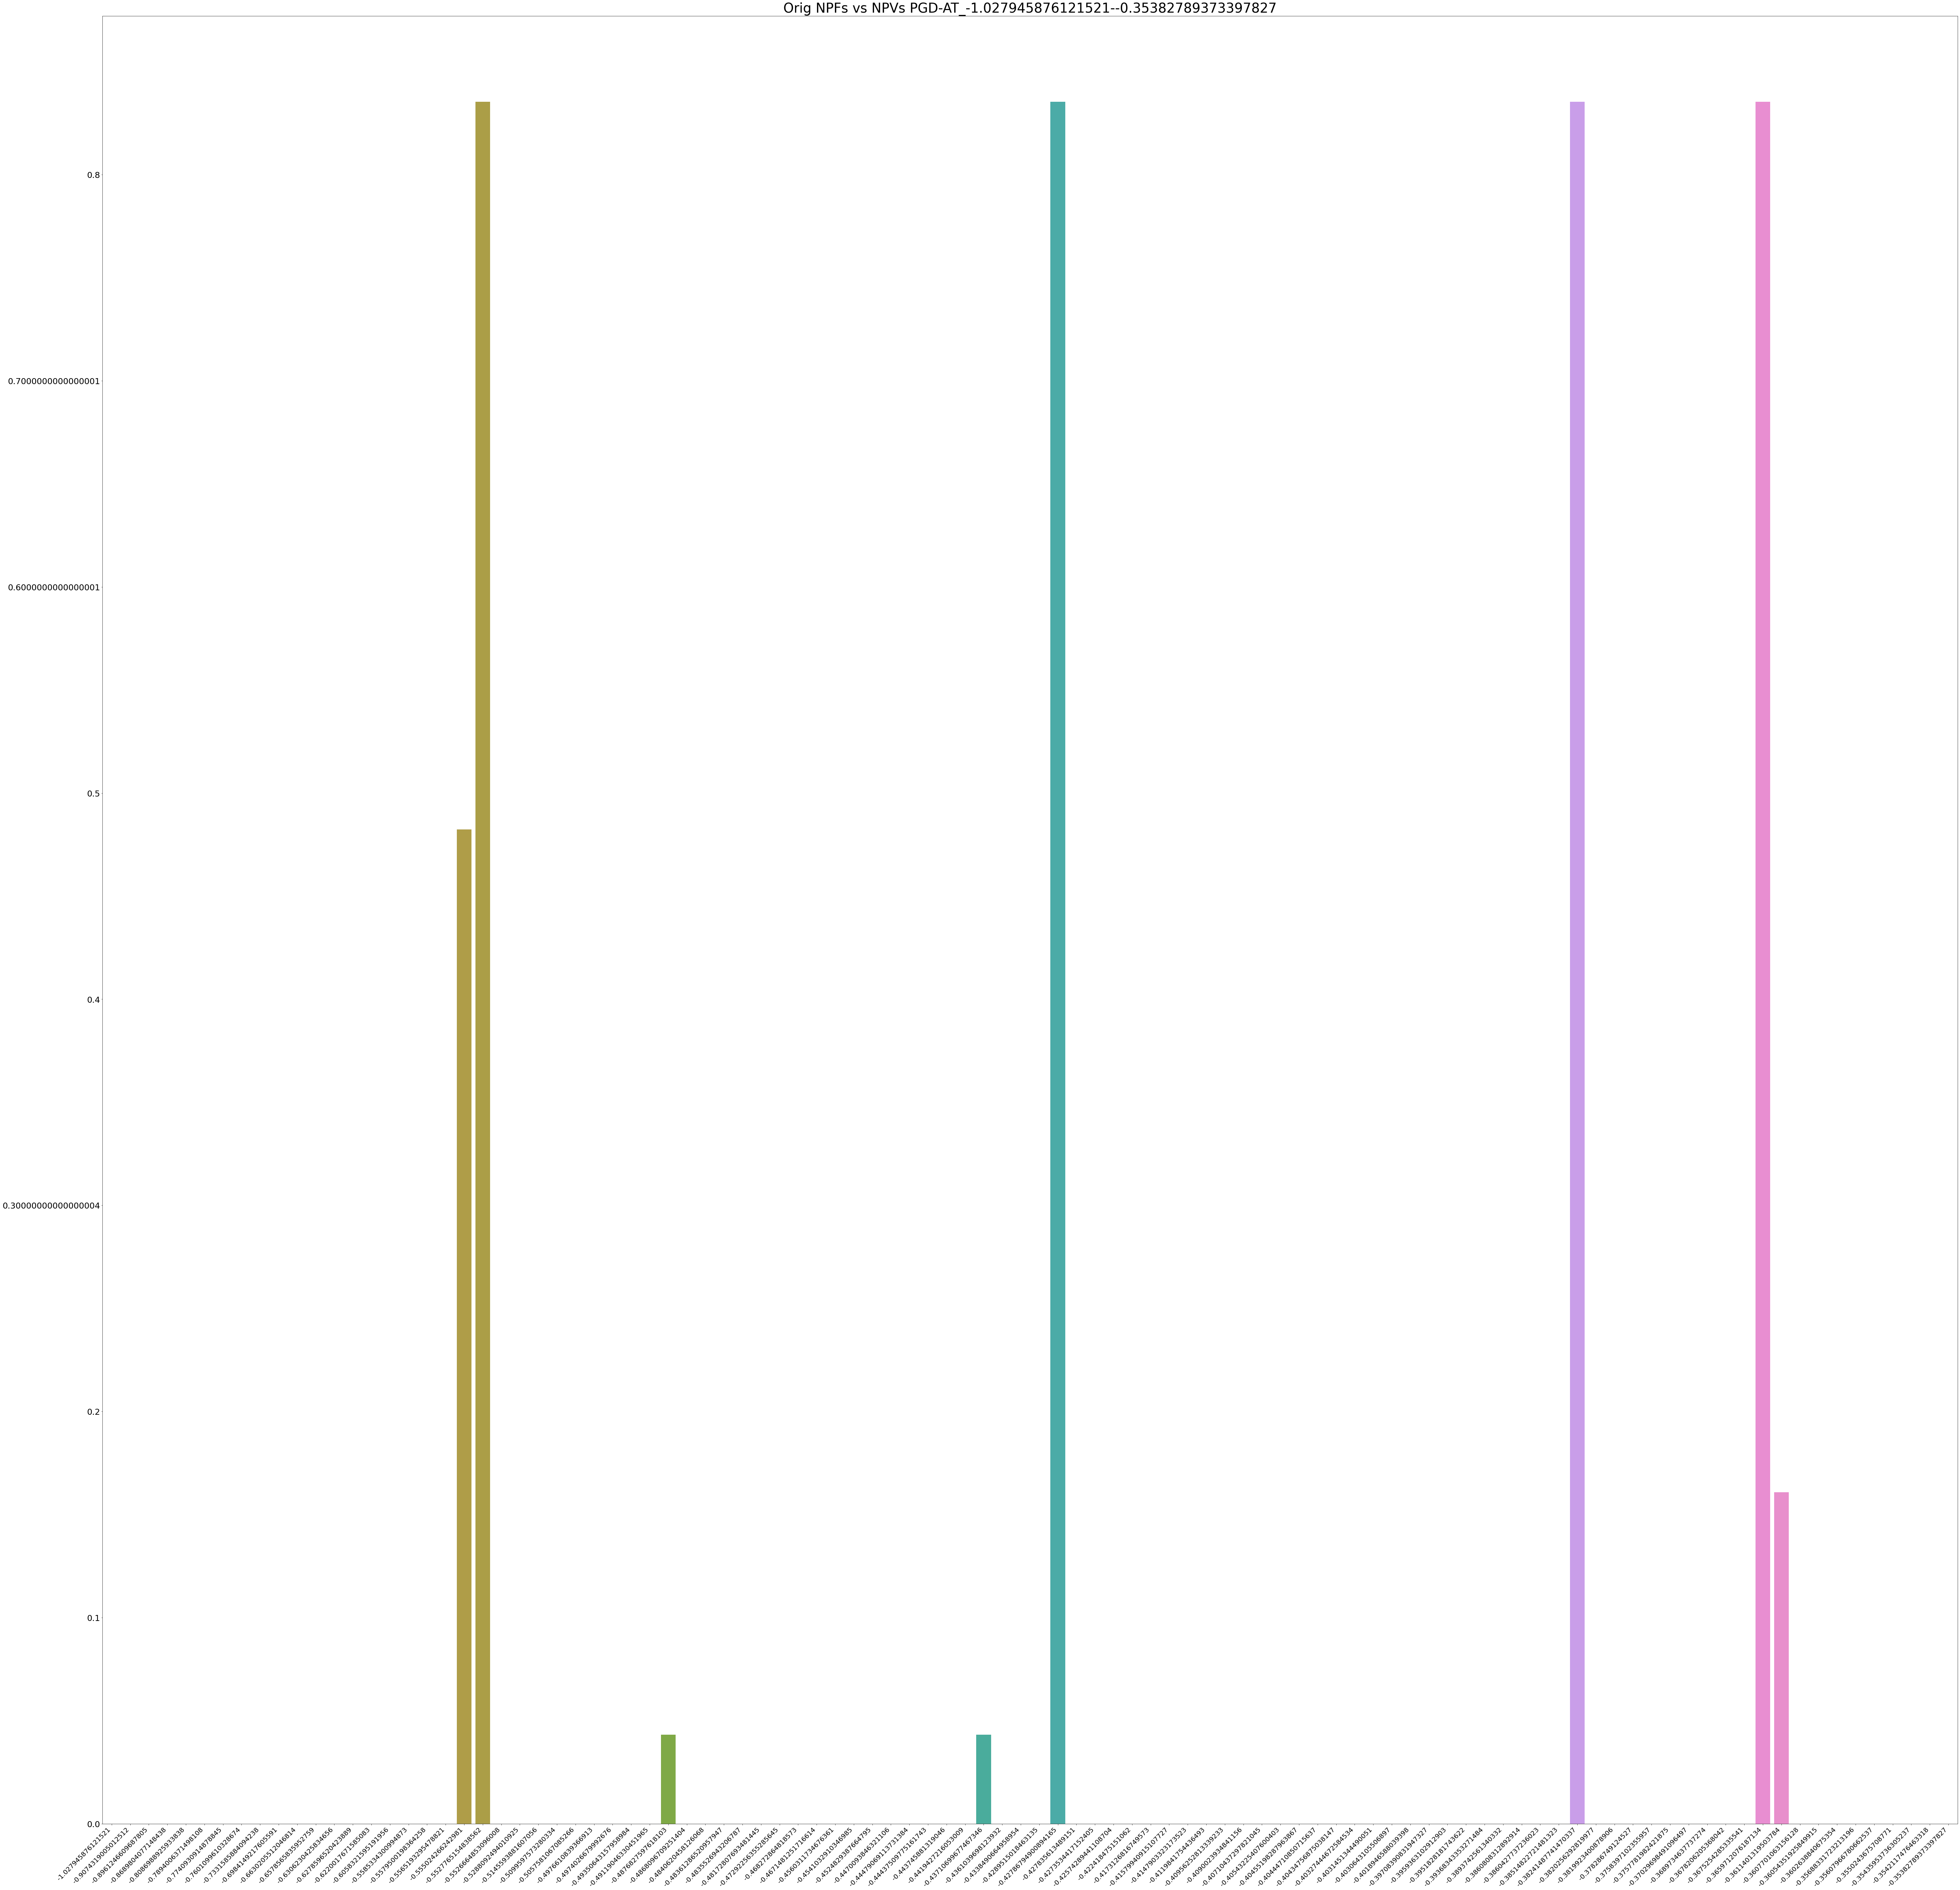

In [138]:
hrelu = HardRelu()
org_inputs = torch.unsqueeze(per_class_eval_dataset[sample_ind][0],0).to(device)

net(org_inputs)
if(not hasattr(net,"value_network")):
    net.linear_conv_outputs.append(net.prev_out)
for indx in range(len(net.linear_conv_outputs)):
    net.linear_conv_outputs[indx] = hrelu(net.linear_conv_outputs[indx])
net.linear_conv_outputs.insert(0,torch.flatten(org_inputs, 1))
npfs = get_NPFs(net.linear_conv_outputs)
output_bar_graph(npvs[overall_sorted_npv_indx[st:end]].tolist(),torch.squeeze(npfs[overall_sorted_npv_indx[st:end]]).tolist(),"Orig NPFs vs NPVs PGD-AT")

/home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


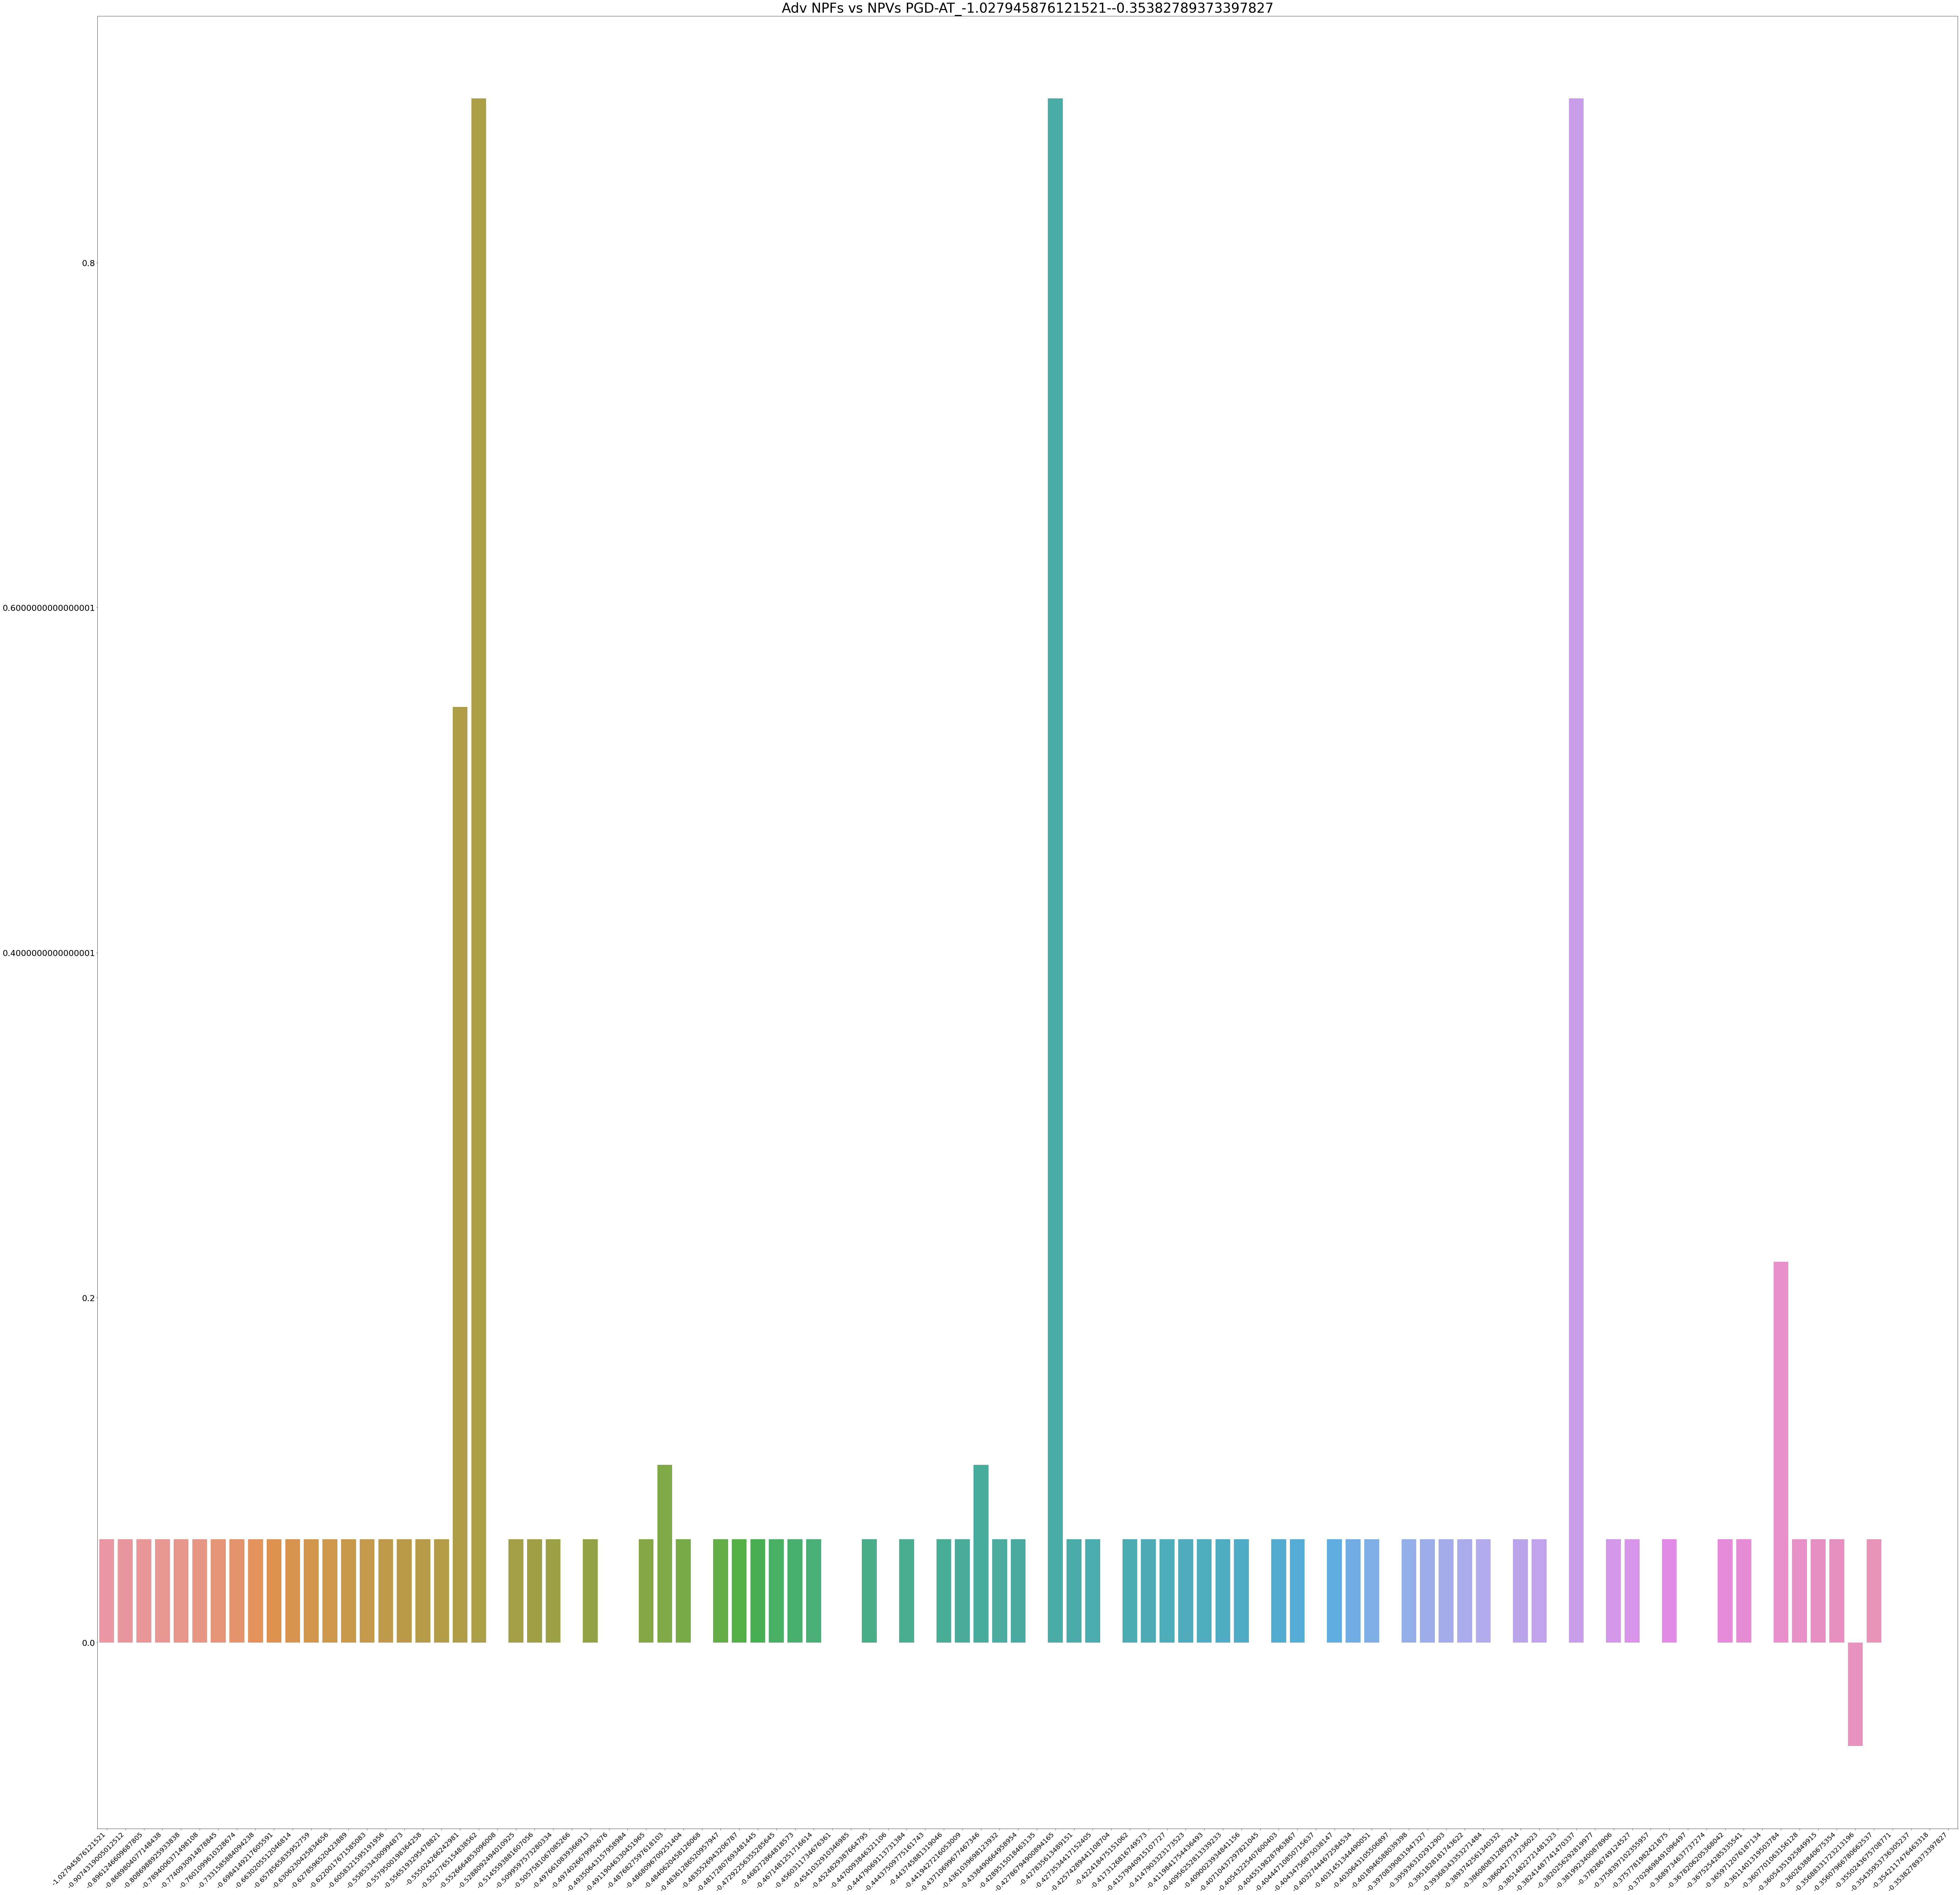

In [139]:
hrelu = HardRelu()
org_inputs = torch.unsqueeze(per_class_tobe_analysed_dataset[sample_ind][0],0).to(device)

net(org_inputs)
if(not hasattr(net,"value_network")):
    net.linear_conv_outputs.append(net.prev_out)
for indx in range(len(net.linear_conv_outputs)):
    net.linear_conv_outputs[indx] = hrelu(net.linear_conv_outputs[indx])
net.linear_conv_outputs.insert(0,torch.flatten(org_inputs, 1))
npfs = get_NPFs(net.linear_conv_outputs)
output_bar_graph(npvs[overall_sorted_npv_indx[st:end]].tolist(),torch.squeeze(npfs[overall_sorted_npv_indx[st:end]]).tolist(),"Adv NPFs vs NPVs PGD-AT")

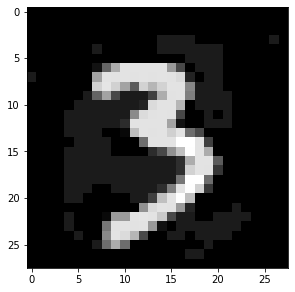

In [140]:
plt.figure(figsize=(6.4, 4.8), constrained_layout=False)
plt.imshow(per_class_tobe_analysed_dataset[sample_ind][0], "gray")